#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, мне нужно спрогнозировать количество заказов такси на следующий час.

Мне предоставлен набор данных.
Ожидаемая точность модели не больше 48 по метрике RMSE

## Подготовка

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error,  make_scorer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

try:
    import pandas_profiling
except:
    !pip install pandas_profiling
    import pandas_profiling

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(pandas_profiling.ProfileReport(df))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Проверка 0 заказов

<AxesSubplot:>

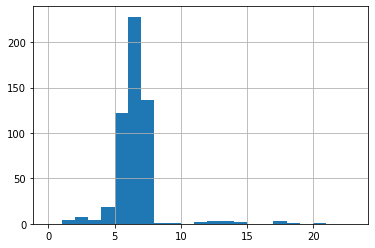

In [4]:
pd.Series(df[df['num_orders']==0].index.hour).hist(bins=range(0,24))

Большая часть чремени без заказов приходится на ночное время и раннее утро. Принято допущение, что это нормальная ситуация для текущего задания

### Выводы

- объем выборки 26496 записей
- дублей в записях нет
- данные выгружены за март-август 2018
- периодичность исходных данных - 10 мин
- в объеме заказов есть 0 позиции, но эти записи чаще приходятся на ночное время, когда клиенская активность низкая. Принято допущение, что это корректные данные. 

## Анализ

### Изменение периодичности

In [5]:
r_df = df.resample('1h').sum()
r_df.shape

(4416, 1)

### Визуализация рядов

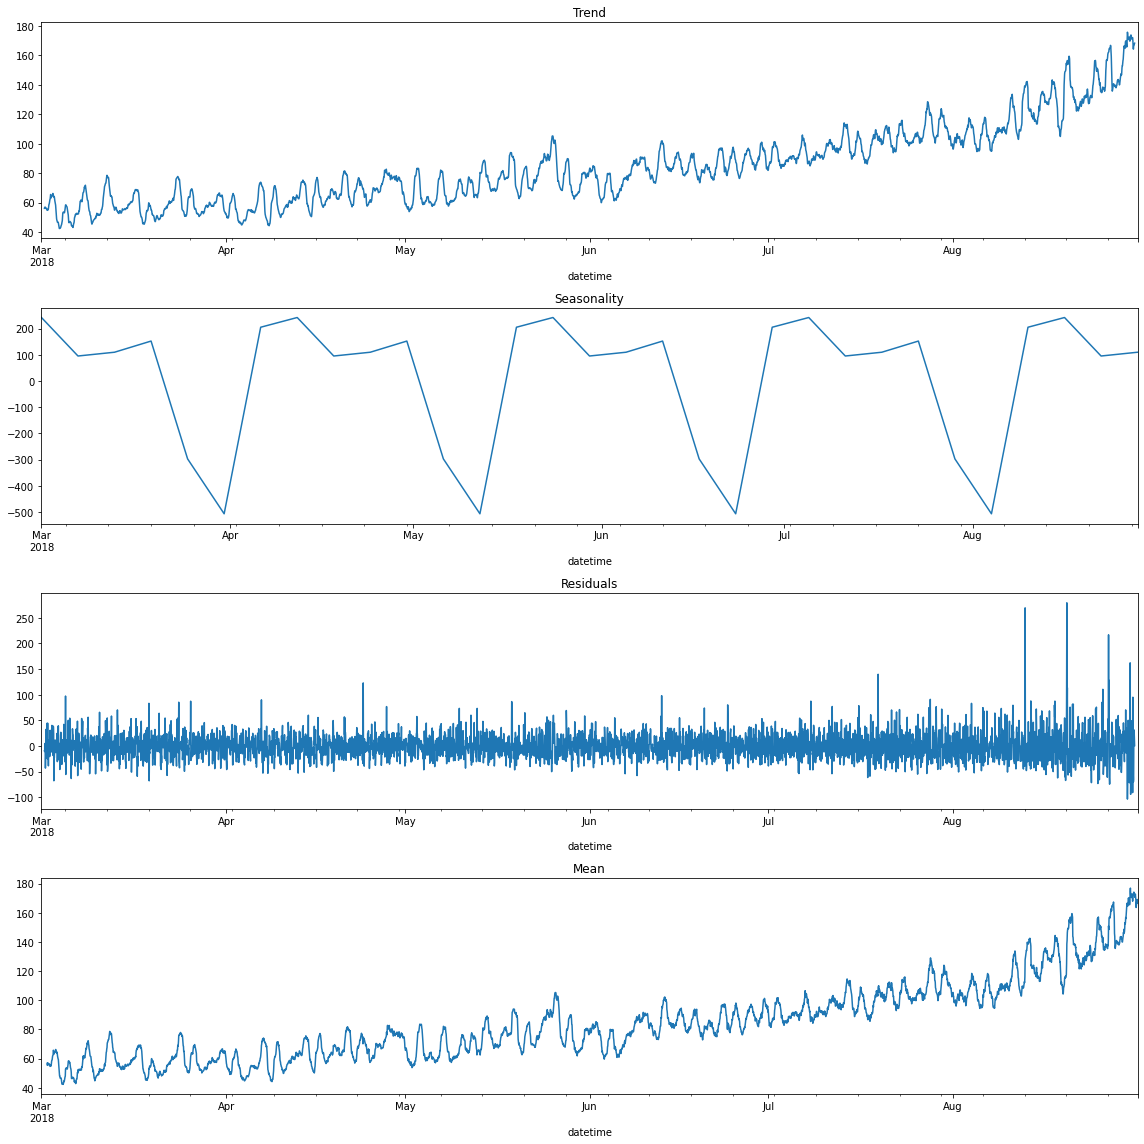

In [6]:
decomposed = seasonal_decompose(r_df)
decomposed_1w = seasonal_decompose(df.resample('6D').sum())


plt.figure(figsize=(16, 16))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(412)
decomposed_1w.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(413)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.subplot(414)
r_df['num_orders'].rolling(24).mean().plot(ax=plt.gca())
plt.title('Mean')
plt.tight_layout()

- наблюдается растущий тренд с начала наблюдений 
- представленные данные представляют стационарный ряд
- по всему периоду наблюдается достаточная волантильность данных

### Анализ лагов

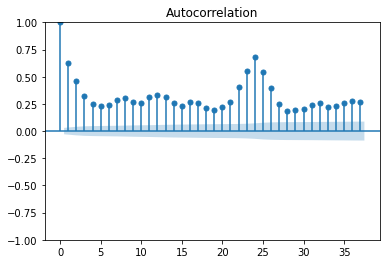

In [7]:
plot_acf(r_df)
plt.show()

- наблюдается высокая автокореляция в районе 22-26 лагов.
- в модель можно ввести до 35 лагов и все они имеют статистическую значимость при построении модели.
- ограничим количество лагов 28.

### Выводы

- наблюдается растущий тренд с начала наблюдений 
- представленные данные представляют не стационарный ряд
- по всему периоду наблюдается достаточная волантильность данных
- наблюдается высокая автокореляция в районе 22-26 лагов.
- в модель можно ввести до 35 лагов и все они имеют статистическую значимость при построении модели.
- ограничим количество лагов 28.


## Обучение

In [8]:
data = []

In [9]:
#функция сглаживания данных
def make_features(df, rolling_mean_size):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [10]:
#добавим лаги в соответствии с исследованием
for lag in range(1, 28):
    r_df['lag_{}'.format(lag)] = r_df['num_orders'].shift(lag, fill_value=np.NaN)

In [11]:
#скорер для поиска MRSE
def rmse(predict, target):
    return mean_squared_error(predict, target)**0.5

In [12]:
#процедура обучения моделей
def learn_model(model, rf_grid, model_name, data, ft, tt, rol_size=1):
        
        score = make_scorer(rmse, greater_is_better=False)

        my_cv = TimeSeriesSplit(n_splits=2)   
        model = GridSearchCV(model, rf_grid, 
                         scoring = score, cv=my_cv, verbose=10)
        model.fit(ft, tt)
        
        data.append([model_name,
                 int(model.best_score_),
                 model.best_params_,
                 rol_size])
        display(model.best_params_)

In [13]:
%%time
#поищем оптимальное скользящее окно

for i in range(1,10):
    m_features  = make_features(r_df, i)
    m_features = m_features.dropna()
    train, test = train_test_split(m_features, shuffle=False, test_size=0.1)
    
    rf_grid ={'fit_intercept': [True, False],
         'normalize': [True, False],
         'positive': [True, False]}
    
    learn_model(LinearRegression(), rf_grid, 'LinearRegression', data, 
                ft=train.drop('num_orders',axis=1), tt=train['num_orders'], rol_size=i)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 1/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.0s
[CV 2/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 2/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 1/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.2s
[CV 2/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.2s
[CV 1/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 1/2; 3/8] END fit_intercept=True, normalize=False, positive=True; total time=   0.1s
[CV 2/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 2/2; 3/

{'fit_intercept': True, 'normalize': False, 'positive': False}

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 1/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 2/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 2/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 1/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 2/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 1/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 1/2; 3/8] END fit_intercept=True, normalize=False, positive=True; total time=   0.0s
[CV 2/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 2/2; 3/

{'fit_intercept': False, 'normalize': True, 'positive': False}

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 1/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 2/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 2/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 1/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 2/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.2s
[CV 1/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 1/2; 3/8] END fit_intercept=True, normalize=False, positive=True; total time=   0.1s
[CV 2/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 2/2; 3/

{'fit_intercept': False, 'normalize': True, 'positive': False}

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 1/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.0s
[CV 2/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 2/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 1/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 2/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.2s
[CV 1/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 1/2; 3/8] END fit_intercept=True, normalize=False, positive=True; total time=   0.1s
[CV 2/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 2/2; 3/

{'fit_intercept': False, 'normalize': True, 'positive': False}

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 1/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 2/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 2/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.0s
[CV 1/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.2s
[CV 2/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.0s
[CV 1/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 1/2; 3/8] END fit_intercept=True, normalize=False, positive=True; total time=   0.1s
[CV 2/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 2/2; 3/

{'fit_intercept': True, 'normalize': False, 'positive': False}

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 1/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 2/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 2/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.0s
[CV 1/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.2s
[CV 2/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 1/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 1/2; 3/8] END fit_intercept=True, normalize=False, positive=True; total time=   0.1s
[CV 2/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 2/2; 3/

{'fit_intercept': True, 'normalize': False, 'positive': False}

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 1/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.0s
[CV 2/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 2/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 1/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 2/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 1/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 1/2; 3/8] END fit_intercept=True, normalize=False, positive=True; total time=   0.1s
[CV 2/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 2/2; 3/

{'fit_intercept': True, 'normalize': False, 'positive': False}

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 1/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 2/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 2/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 1/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.2s
[CV 2/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 1/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 1/2; 3/8] END fit_intercept=True, normalize=False, positive=True; total time=   0.2s
[CV 2/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 2/2; 3/

{'fit_intercept': True, 'normalize': False, 'positive': False}

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 1/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 2/2; 1/8] START fit_intercept=True, normalize=True, positive=True...........
[CV 2/2; 1/8] END fit_intercept=True, normalize=True, positive=True; total time=   0.1s
[CV 1/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 2/2; 2/8] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 2/8] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 1/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 1/2; 3/8] END fit_intercept=True, normalize=False, positive=True; total time=   0.1s
[CV 2/2; 3/8] START fit_intercept=True, normalize=False, positive=True..........
[CV 2/2; 3/

{'fit_intercept': True, 'normalize': False, 'positive': False}

CPU times: user 6.55 s, sys: 12.4 s, total: 18.9 s
Wall time: 19 s


<AxesSubplot:xlabel='features_сount'>

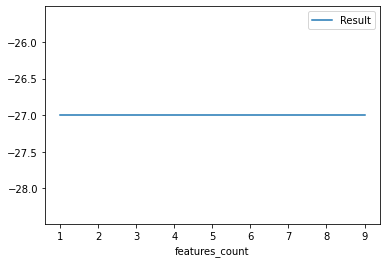

In [14]:
df_ml = pd.DataFrame(data, columns=['Model','Result','Best_params','features_сount'])
df_ml.plot(x='features_сount',y='Result')

In [15]:
#влияние размера окна на точность предсказания не выявлено, будем использовать 1
r_df = make_features(r_df, 1)
r_df = r_df.dropna()
#разделим 90:10
train, test = train_test_split(r_df, shuffle=False, test_size=0.1)

display(train.shape)
display(test.shape)

(3950, 33)

(439, 33)

In [16]:
data = []

### LGBMRegressor

In [17]:
%%time

#Wall time: 8h 54min 43s
rf_grid ={'max_depth': [1, 3, 5, 6, 7, 9],
          'boosting_type':['gbdt','dart','goss','rf'],
          'random_state':[12345],
          'num_iterations':[100,300,500,700,1000],
          'n_estimators':[100,300,500,700,1000]}

rf_grid ={'boosting_type': ['gbdt'],
 'max_depth': [7],
 'n_estimators': [100],
 'num_iterations': [100],
 'random_state': [12345]}

learn_model(lgb.LGBMRegressor(), rf_grid, 'LGBMRegressor', data, 
                ft=train.drop('num_orders',axis=1), tt=train['num_orders'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START boosting_type=gbdt, max_depth=7, n_estimators=100, num_iterations=100, random_state=12345
[CV 1/2; 1/1] END boosting_type=gbdt, max_depth=7, n_estimators=100, num_iterations=100, random_state=12345; total time=   0.5s
[CV 2/2; 1/1] START boosting_type=gbdt, max_depth=7, n_estimators=100, num_iterations=100, random_state=12345
[CV 2/2; 1/1] END boosting_type=gbdt, max_depth=7, n_estimators=100, num_iterations=100, random_state=12345; total time=   0.8s


{'boosting_type': 'gbdt',
 'max_depth': 7,
 'n_estimators': 100,
 'num_iterations': 100,
 'random_state': 12345}

CPU times: user 2.34 s, sys: 0 ns, total: 2.34 s
Wall time: 2.34 s


### Liner Regression

In [18]:
%%time

rf_grid ={'fit_intercept': [True, False],
         'normalize': [True, False],
         'positive': [True, False]}
#Wall time: 1.79 s
rf_grid = {'fit_intercept': [True], 'normalize': [True], 'positive': [False]}

ft=train.drop('num_orders',axis=1)
tt=train['num_orders']

scaler = StandardScaler()
scaler.fit(ft)
ft = scaler.transform(ft)
#tt = scaler.transform(tt)

learn_model(LinearRegression(), rf_grid, 'LinearRegression', data, 
                ft=ft, tt=tt)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START fit_intercept=True, normalize=True, positive=False..........
[CV 1/2; 1/1] END fit_intercept=True, normalize=True, positive=False; total time=   0.1s
[CV 2/2; 1/1] START fit_intercept=True, normalize=True, positive=False..........
[CV 2/2; 1/1] END fit_intercept=True, normalize=True, positive=False; total time=   0.0s


{'fit_intercept': True, 'normalize': True, 'positive': False}

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 198 ms


### GradientBoostingRegressor

In [19]:
%%time

#Wall time: 15min 36s
rf_grid ={'loss': ['ls', 'lad','huber','quantile'],
         'criterion': ['friedman_mse','mse'],
         'max_depth': [int(x) for x in np.linspace(3, 20, num = 10)],
         'random_state':[12345],
         'n_iter_no_change':[5]}

rf_grid ={'criterion': ['mse'],
 'loss': ['ls'],
 'max_depth': [3],
 'n_iter_no_change': [5],
 'random_state': [12345]}

learn_model(GradientBoostingRegressor(), rf_grid, 'GradientBoostingRegressor', data, 
                ft=train.drop('num_orders',axis=1), tt=train['num_orders'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START criterion=mse, loss=ls, max_depth=3, n_iter_no_change=5, random_state=12345
[CV 1/2; 1/1] END criterion=mse, loss=ls, max_depth=3, n_iter_no_change=5, random_state=12345; total time=   0.4s
[CV 2/2; 1/1] START criterion=mse, loss=ls, max_depth=3, n_iter_no_change=5, random_state=12345
[CV 2/2; 1/1] END criterion=mse, loss=ls, max_depth=3, n_iter_no_change=5, random_state=12345; total time=   1.2s


{'criterion': 'mse',
 'loss': 'ls',
 'max_depth': 3,
 'n_iter_no_change': 5,
 'random_state': 12345}

CPU times: user 3.17 s, sys: 0 ns, total: 3.17 s
Wall time: 3.2 s


### RandomForestRegressor

In [20]:
%%time

#Wall time: 1min 29s
rf_grid ={'criterion': ['mse'],
         'max_depth': range(1,20),
         'random_state':[12345]}

#Wall time: 8.29 s
rf_grid ={'criterion': ['mse'], 'max_depth': [17], 'random_state': [12345]}

learn_model(RandomForestRegressor(), rf_grid, 'RandomForestRegressor', data, 
                ft=train.drop('num_orders',axis=1), tt=train['num_orders'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START criterion=mse, max_depth=17, random_state=12345.............
[CV 1/2; 1/1] END criterion=mse, max_depth=17, random_state=12345; total time=   2.0s
[CV 2/2; 1/1] START criterion=mse, max_depth=17, random_state=12345.............
[CV 2/2; 1/1] END criterion=mse, max_depth=17, random_state=12345; total time=   3.9s


{'criterion': 'mse', 'max_depth': 17, 'random_state': 12345}

CPU times: user 12.1 s, sys: 0 ns, total: 12.1 s
Wall time: 12.1 s


### DecisionTreeRegressor

In [21]:
%%time

#Wall time: 3.78 s
rf_grid ={'criterion': ['mse', 'friedman_mse'],
          'splitter': ['best', 'random'],
          'max_depth': range(1,20),
          'random_state':[12345]}

#Wall time: 1min 24s
rf_grid ={'criterion': ['mse'], 'max_depth': [3], 'random_state': [12345], 'splitter': ['best']}

learn_model(DecisionTreeRegressor(), rf_grid, 'DecisionTreeRegressor', data, 
                ft=train.drop('num_orders',axis=1), tt=train['num_orders'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START criterion=mse, max_depth=3, random_state=12345, splitter=best
[CV 1/2; 1/1] END criterion=mse, max_depth=3, random_state=12345, splitter=best; total time=   0.0s
[CV 2/2; 1/1] START criterion=mse, max_depth=3, random_state=12345, splitter=best
[CV 2/2; 1/1] END criterion=mse, max_depth=3, random_state=12345, splitter=best; total time=   0.0s


{'criterion': 'mse', 'max_depth': 3, 'random_state': 12345, 'splitter': 'best'}

CPU times: user 60.7 ms, sys: 0 ns, total: 60.7 ms
Wall time: 62.2 ms


### SGDRegressor

In [22]:
%%time
#Wall time: 5min 58s
rf_grid ={'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
         'penalty': ['l2', 'l1', 'elasticnet'],
         'shuffle': [False],
         'random_state':[0],
         'learning_rate':['constant','optimal','invscaling','adaptive'],
         'max_iter':[int(x) for x in np.linspace(1000, 10000, num = 10)]}

rf_grid = {'learning_rate': ['adaptive'],
 'loss': ['squared_epsilon_insensitive'],
 'max_iter': [1000],
 'penalty': ['l1'],
 'random_state': [0],
 'shuffle': [False]}

ft=train.drop('num_orders',axis=1)
tt=train['num_orders']

scaler = StandardScaler()
scaler.fit(ft)
ft = scaler.transform(ft)

learn_model(SGDRegressor(), rf_grid, 'SGDRegressor', data, 
                ft=ft, tt=tt)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1, random_state=0, shuffle=False
[CV 1/2; 1/1] END learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1, random_state=0, shuffle=False; total time=   0.3s
[CV 2/2; 1/1] START learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1, random_state=0, shuffle=False
[CV 2/2; 1/1] END learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1, random_state=0, shuffle=False; total time=   0.7s


{'learning_rate': 'adaptive',
 'loss': 'squared_epsilon_insensitive',
 'max_iter': 1000,
 'penalty': 'l1',
 'random_state': 0,
 'shuffle': False}

CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.31 s


### Анализ моделей

,Model,Result,Best_params,features_сount
0,LGBMRegressor,-27,"{'boosting_type': 'gbdt', 'max_depth': 7, 'n_e...",1
1,LinearRegression,-27,"{'fit_intercept': True, 'normalize': True, 'po...",1
5,SGDRegressor,-27,"{'learning_rate': 'adaptive', 'loss': 'squared...",1
2,GradientBoostingRegressor,-28,"{'criterion': 'mse', 'loss': 'ls', 'max_depth'...",1
3,RandomForestRegressor,-28,"{'criterion': 'mse', 'max_depth': 17, 'random_...",1
4,DecisionTreeRegressor,-33,"{'criterion': 'mse', 'max_depth': 3, 'random_s...",1


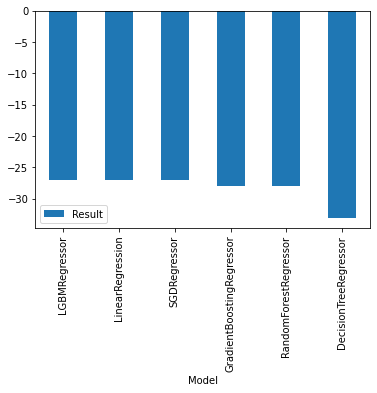

In [23]:
df_ml = pd.DataFrame(data, columns=['Model','Result','Best_params','features_сount'])
df_ml.sort_values('Result', ascending=False, inplace=True)
df_ml.plot(x='Model',y='Result',kind='bar')
df_ml

Из шести рассмотренных моделей наибольшую точность показала модель LGBMRegressor.

## Тестирование

### Проверка на выбранной моделе

In [28]:
model = lgb.LGBMRegressor(boosting_type='gbdt', max_depth= 7, n_estimators= 100, num_iterations= 100, random_state= 12345)
model.fit(train.drop('num_orders',axis=1), train['num_orders'])
prediction = model.predict(test.drop('num_orders',axis=1))
print('RMSE:', rmse(test['num_orders'],prediction))

RMSE: 41.6512315362211


<AxesSubplot:>

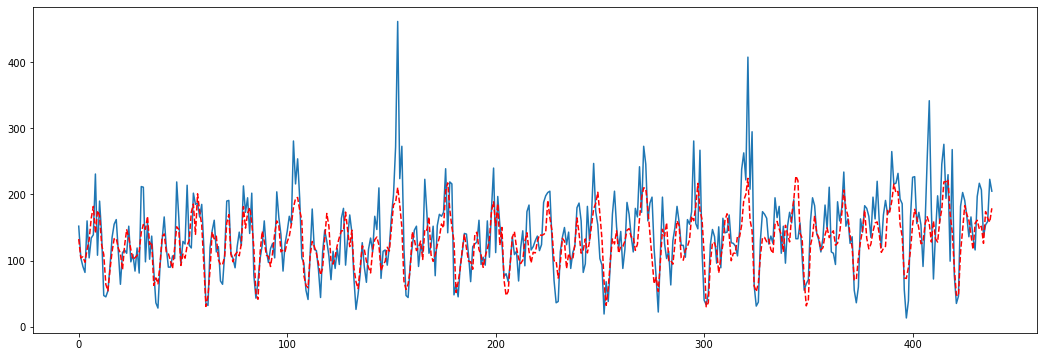

In [29]:
pd.Series(np.array(test['num_orders'])).plot(figsize=(18,6))
pd.Series(prediction).plot(style='r--')

### Проверка на простейшей моделе

In [30]:
model = DummyRegressor()
model.fit(train.drop('num_orders',axis=1), train['num_orders'])
prediction = model.predict(test.drop('num_orders',axis=1))
print('RMSE:',rmse(test['num_orders'],prediction))

RMSE: 84.72344139925762


<AxesSubplot:>

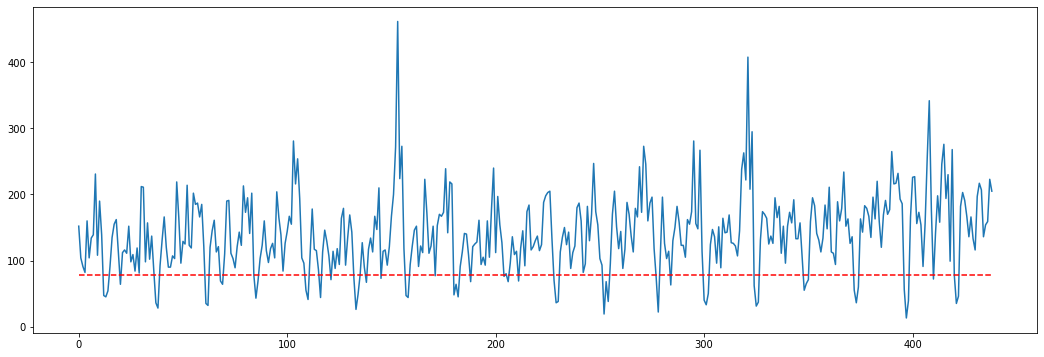

In [31]:
pd.Series(np.array(test['num_orders'])).plot(figsize=(18,6))
pd.Series(prediction).plot(style='r--')

## Выводы

- объем выборки 26496 записей
- дублей в записях нет
- данные выгружены за март-август 2018
- периодичность исходных данных - 10 мин
- в объеме заказов есть 0 позиции, но эти записи чаще приходятся на ночное время, когда клиенская активность низкая. Принято допущение, что это корректные данные.
- наблюдается растущий тренд с начала наблюдений 
- представленные данные представляют стационарный ряд
- по всему периоду наблюдается достаточная волантильность данных
- наблюдается высокая автокореляция в районе 22-26 лагов.
- в модель можно ввести до 35 лагов и все они имеют статистическую значимость при построении модели.
- ограничим количество лагов 28.
- выбранная модель обладает более высокими показателями, чем простейшая.